In [2]:
# from pydub import AudioSegment

# # Load the MP3 file
# mp3_file = 'test.mp3'
# audio = AudioSegment.from_mp3(mp3_file)

# # Define the output WAV file path
# wav_file = 'test.wav'

# # Export the audio as WAV
# audio.export(wav_file, format='wav')


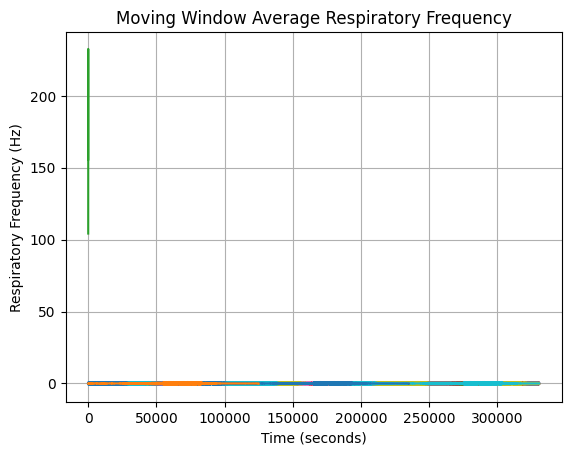

In [15]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# Load the audio file
audio_file = 'test.mp3'
audio_data, sr = librosa.load(audio_file)

# Set the window size and overlap in seconds
window_size = 15
overlap = 5

# Calculate the number of samples in the window
window_samples = int(sr * window_size)
overlap_samples = int(sr * overlap)

# Calculate the number of windows in the audio
num_windows = len(audio_data) // overlap_samples

# Initialize arrays to store the respiratory frequency and time for each window
respiratory_frequencies = np.zeros(num_windows)
window_times = np.zeros(num_windows)

# Iterate over each window
for i in range(num_windows):
    # Calculate the start and end samples of the current window
    start = i * overlap_samples
    end = start + window_samples

    # Extract the current window
    window = audio_data[start:end]
    
    plt.plot(window)

    # Calculate the envelope of the window using Hilbert transform
    envelope = np.abs(hilbert(window))

    # Calculate the short-term Fourier transform (STFT) of the envelope
    stft = np.abs(librosa.stft(envelope))

    # Calculate the spectral centroid of the STFT
    spectral_centroids = librosa.feature.spectral_centroid(S=stft, sr=sr)

    # Find the index of the peak spectral centroid
    peak_index = np.argmax(spectral_centroids)

    # Calculate the respiratory frequency in Hz
    respiratory_frequency = spectral_centroids[0, peak_index] * sr / len(window)

    # Store the respiratory frequency and time for the current window
    respiratory_frequencies[i] = respiratory_frequency
    window_times[i] = start / sr

# Calculate the moving average of the respiratory frequency
window_size_sec = window_size - overlap
moving_average = np.convolve(respiratory_frequencies, np.ones(window_size_sec) / window_size_sec, mode='same')

# Create a time array for the moving average
moving_average_times = np.linspace(window_size_sec / 2, len(audio_data) / sr - window_size_sec / 2, len(moving_average))

# Plot the moving average calculated frequency vs time
plt.plot(moving_average_times, moving_average)
plt.xlabel('Time (seconds)')
plt.ylabel('Respiratory Frequency (Hz)')
plt.title('Moving Window Average Respiratory Frequency')
plt.grid(True)
plt.show()


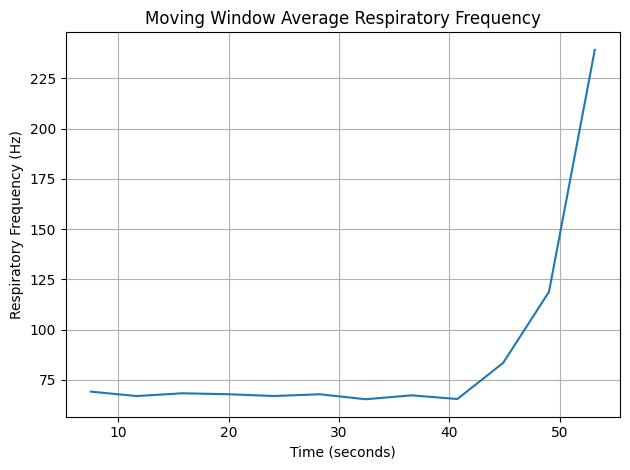

In [50]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy import interpolate
from scipy.signal import hilbert, butter, filtfilt


# Load the audio file
audio_file = 'test.mp3'
audio_data, sr = librosa.load(audio_file)


# Set the window size and overlap in seconds
window_size = 20
overlap = 5

# Calculate the number of samples in the window
window_samples = int(sr * window_size)
overlap_samples = int(sr * overlap)

# Calculate the number of windows in the audio
num_windows = len(audio_data) // overlap_samples

# Calculate the moving average of the respiratory frequency
window_size_sec = window_size - overlap
moving_average = np.zeros(num_windows)

# Create an array to store the mosaic plots
mosaics = np.zeros((num_windows, window_samples))

cutoff_freq = 3  # in Hz

# Calculate the filter coefficients
b, a = butter(4, cutoff_freq / (sr / 2), btype='low')

# Iterate over each window
for i in range(num_windows):
    # Calculate the start and end samples of the current window
    start = i * overlap_samples
    end = start + window_samples

    # Extract the current window
    window = audio_data[start:end]

    # Calculate the envelope of the window using Hilbert transform
    envelope = np.abs(hilbert(window))
    
    # Set the lowpass filter parameters
   

    # Apply the lowpass filter to the signal
    envelope = filtfilt(b, a, envelope)
    
    # Apply UnivariateSpline interpolation with smoothing factor of 3000
    spline = interpolate.UnivariateSpline(np.arange(len(envelope)), envelope, s=2000)
    interpolated_envelope = spline(np.arange(len(envelope)))


    # Calculate the short-term Fourier transform (STFT) of the envelope
    stft = np.abs(librosa.stft(envelope))
    #fouriers[i,:,:] = stft
    # Calculate the spectral centroid of the STFT
    spectral_centroids = librosa.feature.spectral_centroid(S=stft, sr=sr)

    # Find the index of the peak spectral centroid
    peak_index = np.argmax(spectral_centroids)

    # Calculate the respiratory frequency in Hz
    respiratory_frequency = spectral_centroids[0, peak_index] * sr / len(window)

    # Store the respiratory frequency in the moving average array
    moving_average[i] = respiratory_frequency

    # Store the windowed data in the mosaic array
    #mosaics[i] = window

    # # # Plot the current windowed data
    # plt.figure()
    # plt.plot(stft)
    # plt.xlabel('Sample')
    # plt.ylabel('Amplitude')
    # plt.title(f'Window {i+1}')
    # plt.grid(True)

# Create a time array for the moving average
moving_average_times = np.linspace(window_size_sec / 2, len(audio_data) / sr - window_size_sec / 2, len(moving_average))

# Plot the moving average calculated frequency vs time
plt.figure()
plt.plot(moving_average_times, moving_average)
plt.xlabel('Time (seconds)')
plt.ylabel('Respiratory Frequency (Hz)')
plt.title('Moving Window Average Respiratory Frequency')
plt.grid(True)

# # Display the mosaic of windowed data
# fig, axes = plt.subplots(num_windows, 1, figsize=(8, 6))
# for i in range(num_windows):
#     axes[i].plot(mosaics[i])
#     axes[i].set_xlabel('Sample')
#     axes[i].set_ylabel('Amplitude')
#     axes[i].set_title(f'Window {i+1}')
#     axes[i].grid(True)

plt.tight_layout()
plt.show()


In [31]:
respiratory_frequency

243.08830694294932

In [42]:
fouriers = np.empty([num_windows,stft.shape[0],stft.shape[1]])


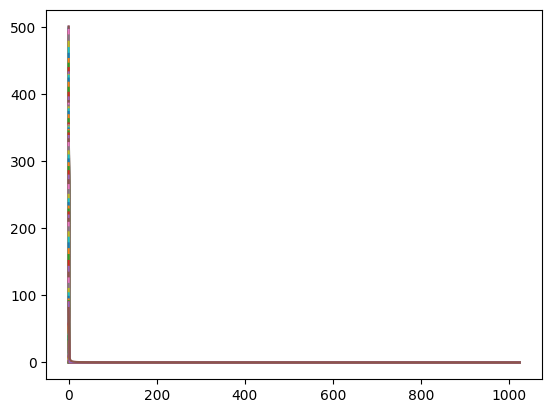

In [46]:
plt.plot(fouriers[0,:,:])

(1025, 646)